In [1]:
import numpy as np 
import re
import cupy as cp
import pickle
import time
import numpy as np 
import pandas as pd
import numpy as np 
import spacy
from tqdm import tqdm
from pathlib import Path
import json

np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))


def log_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record start time
        result = func(*args, **kwargs)  # Execute the wrapped function
        end_time = time.time()  # Record end time
        elapsed_time = end_time - start_time
        # print(f"Function '{func.__name__}' executed in {elapsed_time:.4f} seconds")
        return result

    return wrapper


class Helper: 
    
    def get_positional_encoding(self,seq_len, d_model):
        """
        Returns a non-learnable (sinusoidal) positional encoding.


        seq_len: Length of the input sequence.
        d_model: Dimension of the embeddings.
        """
        pos = cp.arange(seq_len)[:, cp.newaxis]  # Shape: [seq_len, 1]
        i = cp.arange(d_model)[cp.newaxis, :]  # Shape: [1, d_model]

        angle_rates = 1 / cp.power(10000, (2 * (i // 2)) / cp.float32(d_model))

        # Apply sine to even indices, cosine to odd indices
        pos_encoding = cp.zeros((seq_len, d_model))
        pos_encoding[:, 0::2] = cp.sin(pos * angle_rates[:, 0::2])  # sine on even indices
        pos_encoding[:, 1::2] = cp.cos(pos * angle_rates[:, 1::2])  # cosine on odd indices

        return pos_encoding

    @staticmethod
    def softmax(x):
        # Subtract the max value for numerical stability
        max_logits = cp.max(x, axis=-1, keepdims=True)
        exp_logits = cp.exp(x - max_logits)
        return exp_logits / cp.sum(exp_logits, axis=-1, keepdims=True)

 
    # @log_time
    def pad_sequence(self,seq, max_len, pad_value=0):
        """Pad a sequence with a given value up to max_len."""
        current_len = seq.shape[0]
        pad_width = max_len - current_len
        if pad_width > 0:
            # Pad sequence with zeros (or any pad_value you provide)
            seq = cp.pad(seq, ((0, pad_width), (0, 0)), mode='constant', constant_values=pad_value)
        return seq


    @log_time
    def create_timestaped_input(self,input_d, words_per_phrase):
        input_translation = []
        for j in range(input_d.shape[0]):
            # Create padded sequences
            padded_sequences = [self.pad_sequence(input_d[j][0:i], words_per_phrase) for i in range(1, input_d.shape[1] + 1)]
            input_translation.append(padded_sequences)
        return cp.array(input_translation)


    



 
    def redimension(self,X):
        return cp.concatenate(cp.swapaxes(X, 0, 1), axis=-1)
    
    @log_time
    def create_vocabulary(self,complete_text, name, nlp):
        vocabulary_file = f"data/{name}.pkl"
        try:
            with open(vocabulary_file, 'rb') as handle:
                vocabulary = pickle.load(handle)
                print("Vocabulary loaded from file.")
                return vocabulary
        except FileNotFoundError:
            print("Vocabulary file not found, creating a new one.")
        # Use re.findall to split considering punctuation
        text = re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', complete_text)

        words_list = list(set(text))

        vocabulary = dict()

        for i, j in enumerate(words_list):
            # vocabulary[j]=(jax.random.uniform(jax.random.key(cp.random.randint(10000)),embedding_size),i)
            vocabulary[j] = (cp.array(nlp(j).vector), i)
             # print(j,len(cp.array(nlp(j).vector)))

        # print(vocabulary)
        # print("Vocabulary size: ", len(vocabulary))
        with open(vocabulary_file, 'wb') as handle:
            pickle.dump(vocabulary, handle, protocol=pickle.HIGHEST_PROTOCOL)

        return vocabulary


    @log_time
    def pad_sequences(self,sentences, lenght, pad_token='[PAD]', target_type=None):
        """
        Pads the input sentences to have the same length by adding [PAD] tokens at the end.
        """
        regex_str=r'\[.*?\]|\w+|[^\w\s]|\n'

        if target_type == "encoder":
            # Split each sentence into words
            tokenized_sentences = [["[START]"] + re.findall(regex_str, sentence) + ["[END]"] for sentence in sentences]
        elif target_type == "decoder":
            tokenized_sentences = [["[START]"] + re.findall(regex_str, sentence) for sentence in sentences]
        elif target_type == "target":
            tokenized_sentences = [re.findall(regex_str, sentence) + ["[END]"] for sentence in sentences]
        # print(tokenized_sentences)
        if lenght == 0:
            # Find the maximum sentence length
            max_len = max(len(sentence) for sentence in tokenized_sentences)
        else:
            max_len = lenght

        # Pad each sentence with the [PAD] token to make them of equal length
        padded_sentences = [" ".join(sentence + [pad_token] * (max_len - len(sentence))) for sentence in
                            tokenized_sentences]

        return padded_sentences

    def print_matrix(self,text="",X=None):
        for i in X:
            print(text,i)
    
    def create_padding_mask(self,seq):
    # Create a mask with 0 for padded tokens and 1 for real tokens
        return (seq != 0).astype(cp.float32)[..., None]

   
    
    @log_time
    def create_input_encoder(self,X, vocabulary_encoder, max_words_per_phrase, embedding_size):

        pos_encoding = self.get_positional_encoding(max_words_per_phrase, embedding_size)
        #print(pos_encoding)
        #inputs_e,input_e_words,mask = self.generate_input_encoder(X, vocabulary_encoder, max_words_per_phrase)
        
        regex_str=r'\[.*?\]|\w+|[^\w\s]|\n'

        x_train = self.pad_sequences(X, max_words_per_phrase, target_type="encoder")# here are string
        
       
        xi = []
        
        input_e_words = [re.findall(regex_str, x) for x in x_train]
        
        phrase_vectors_x = [i[0:max_words_per_phrase] for i in input_e_words]


        indices = cp.array([[vocabulary_encoder[word][1] for word in phrase_vector] for phrase_vector in phrase_vectors_x])
        mask = (indices != vocabulary_encoder["[PAD]"][1]).astype(cp.float32)[..., None]
        #print(phrase_vectors_x) 
       
        # print("input_encoder:")
        # self.print_matrix(phrase_vectors_x)
        xi = cp.array([[vocabulary_encoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_x])
        word_indexes=cp.array([[vocabulary_encoder[word][1] for word in phrase_vector] for phrase_vector in phrase_vectors_x])
        inputs_e =xi + pos_encoding

        return inputs_e,input_e_words,mask,word_indexes
    
    def generate_target(self,x_batch, vocabulary, max_words_per_phrase):

        regex_str=r'\[.*?\]|\w+|[^\w\s]|\n'

        y_target = self.pad_sequences(x_batch, max_words_per_phrase, target_type="target")# here are one string with the padd
        
        
        target_vector = [re.findall(regex_str, x) for x in y_target]

        #print(target_vector)
        #print_matrix(phrase_vectors_x) 
        #target_vector = [i[0:max_words_per_phrase] for i in target_vector]
        target_vector_i = [i[0:max_words_per_phrase] for i in target_vector]

        indices = cp.array([[vocabulary[word][1] for word in phrase_vector] for phrase_vector in target_vector_i])
        mask = (indices != vocabulary["[PAD]"][1]).astype(cp.float32)[..., None]

        target_vector = cp.array([[self.get_one_hot(i,vocabulary) for i in phrase] for phrase in target_vector_i])
    
        return target_vector,target_vector_i,mask
    
    def generate_target_sparse_categorical(self,y_batch, vocabulary, max_words_per_phrase):

        len_phrase=max_words_per_phrase#+1
        regex_str=r'\[.*?\]|\w+|[^\w\s]|\n'

        y_target = self.pad_sequences(y_batch, max_words_per_phrase, target_type="target")# here are one string with the padd
        
        
        target_vector = [re.findall(regex_str, x) for x in y_target]

        #print(target_vector)
        #print_matrix(phrase_vectors_x) 
        #target_vector = [i[0:max_words_per_phrase] for i in target_vector]
        target_vector_i = [i[0:len_phrase] for i in target_vector]

        indices = cp.array([[vocabulary[word][1] for word in phrase_vector] for phrase_vector in target_vector_i])
        mask = (indices != vocabulary["[PAD]"][1]).astype(cp.float32)[..., None]


        target_vector = cp.array([[vocabulary[i][1] for i in phrase] for phrase in target_vector_i])
    
        return target_vector,target_vector_i,mask
    
    @log_time
    def create_target(self,X, vocabulary_encoder, max_words_per_phrase): 
        target,target_words,mask = self.generate_target(X, vocabulary_encoder, max_words_per_phrase) 
        return target,target_words,mask
    
    @log_time
    def create_target_sparse(self,X, vocabulary_encoder, max_words_per_phrase): 
        target,target_words,mask = self.generate_target_sparse_categorical(X, vocabulary_encoder, max_words_per_phrase) 
        return target,target_words,mask
    @log_time
    def create_decoder_input(self,y_train, embedding_size, max_words_per_phrase, vocabulary_decoder):
        len_phrase=max_words_per_phrase#+1

        decoder_input = self.pad_sequences(y_train, lenght=max_words_per_phrase, target_type="decoder")
        
        decoder_input = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', i) for i in decoder_input]
        #print(len(decoder_input[0]))
        if max_words_per_phrase == None:
            max_words_per_phrase = len(decoder_input[0])

        phrase_vectors_y = [i[0:len_phrase] for i in decoder_input]
        #print(phrase_vectors_y)
        indices = cp.array([[vocabulary_decoder[word][1] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
        mask = (indices != vocabulary_decoder["[PAD]"][1]).astype(cp.float32)[..., None]
        yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
        word_indexes=  cp.array([[vocabulary_decoder[word][1] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
        
        pos_encoding = self.get_positional_encoding(len_phrase, embedding_size)
   
        yi = yi + pos_encoding
      
        return yi,phrase_vectors_y,mask,word_indexes
    @log_time
    def create_decoder_input_teacher_forcing(self,y_train, embedding_size, max_words_per_phrase, vocabulary_decoder):

        decoder_input = self.pad_sequences(y_train, lenght=max_words_per_phrase, target_type="decoder")
        #print_matrix(decoder_input)
        decoder_input = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', i) for i in decoder_input]
        
        if max_words_per_phrase == None:
            max_words_per_phrase = len(decoder_input[0])

        phrase_vectors_y = [i[0:max_words_per_phrase] for i in decoder_input]
        # for sentence in phrase_vectors_y:
        #     print(sentence)
        #print_matrix(phrase_vectors_y)
        indices = cp.array([[vocabulary_decoder[word][1] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
        mask = (indices != vocabulary_decoder["[PAD]"][1]).astype(cp.float32)[..., None]
       

        # print("decoder_input:")
        # self.print_matrix(decoder_input)
        yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
        
        pos_encoding = self.get_positional_encoding(max_words_per_phrase, embedding_size)
        # print(pos_encoding.shape,yi.shape)
        yi = yi + pos_encoding
        #print_matrix(yi)
        decoder_inputs = cp.array(cp.swapaxes(self.create_timestaped_input(yi, max_words_per_phrase), 0, 1))
        
        # decoder_inputs[zero_rows] = vocabulary_decoder["[PAD]"][0]
        for i in range(decoder_inputs.shape[0]):
            for j in range(decoder_inputs[i].shape[0]):
                zero_rows = cp.all(decoder_inputs[i][j] == 0, axis=1)

                decoder_inputs[i][j][zero_rows] = vocabulary_decoder["[PAD]"][0]

        decoder_inputs = cp.array(decoder_inputs)
        #print(decoder_inputs[2])
        #print(decoder_inputs)
        return decoder_inputs,phrase_vectors_y,mask
    # @log_time
    def update_wembedding_encoder(self,learning_rate, x_batch, dLoss_dWemb_encoder, vocabulary, max_words_per_phrase):
        
        x_train = self.pad_sequences(x_batch, max_words_per_phrase, target_type="encoder")

        phrase_vectors_x = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in x_train]
        phrase_vectors_x = [i[:max_words_per_phrase] for i in phrase_vectors_x]

        for phrase in range(dLoss_dWemb_encoder.shape[0]):
            for position, word in enumerate(phrase_vectors_x[phrase]):
                # Retrieve current embedding
                current_embedding, index = vocabulary[word]

                # Calculate the updated embedding using the gradient
                updated_embedding = current_embedding - learning_rate * dLoss_dWemb_encoder[phrase][position]

                # Update the vocabulary with the new embedding
                vocabulary[word] = (updated_embedding, index)

        return vocabulary



    # @log_time
    def update_wembedding(self,updated_vectors,input_words,vocabulary):
        special_tokens=["[PAD]","[START]","[END]","\n"]
        #print("updated_vectors",updated_vectors.shape)
        for phrase_index in range(len(updated_vectors)):
            for word_index in range(len(updated_vectors[phrase_index])):
                word=input_words[phrase_index][word_index] 
                if word not in special_tokens: 
                    #print(word)
                    vocabulary[word]=(updated_vectors[phrase_index][word_index],vocabulary[word][1])
        return vocabulary

  
    # @log_time
    def get_one_hot(self,word, vocabulary_decoder):
        # print(word)
        vocab_size = len(vocabulary_decoder)
        one_hot_vector = cp.zeros(vocab_size)
        one_hot_vector[vocabulary_decoder[word][1]] = 1
        # print(vocabulary_decoder[word][1])
        # print(np.where(one_hot_vector== 1))
        # print(cp.sum(one_hot_vector))
        return one_hot_vector
 
    
    def log_sparse_entropy(self,ans,target,y_batch,step):
        #print("target",target)
        #print("ans",ans)
        counter_found=0
        total_lenght=len(ans)
        print(f"----DECODER--step {step}---")
        self.print_matrix(y_batch)
        print("target",target)
        indexes=[]
        yy=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in y_batch] 
        for idx, values in enumerate(ans):
            max_index = cp.argmax(values)
            indexes.append(max_index)
             
            if max_index==target[idx]:
                counter_found+=1
            print(f"{idx + 1} base: {' '.join(yy[idx][0:step+1])} -> {max_index}")
        print("indexes",indexes)
        print("accuracy batch:",round(counter_found/total_lenght,2))
        
    def accruacy_sparse_entropy(self,ans,target):
        counter_found=0
        total_lenght=len(ans) 
        for idx, values in enumerate(ans):
            max_index = cp.argmax(values) 
            if max_index==target[idx]:
                counter_found+=1
             
        accuracy_batch_on_step=round(counter_found/total_lenght,2)
        return accuracy_batch_on_step
    

    def print_target_vs_prediction_sparce_loss(self,ans,target): 
        indexes=[] 
        for idx, values in enumerate(ans):
            max_index = np.argmax(values).item()
            indexes.append(max_index) 
        print("target",target)
        print("indexes",indexes)
        
  
# def clip_gradient(gradient,threshold):
#     return cp.clip(gradient, -threshold, threshold)


    
    
    
    

class layer_dropout: 

    def __init__(self,dropout_rate=0.1):
        self.dropout_rate=dropout_rate 
        self.mask = None

    def forward(self,X):   
        self.mask = (cp.random.rand(*X.shape) > self.dropout_rate)#.astype(cp.float64)
        result = X * self.mask 
        #print(self.mask )
        return result
    #
    def grad(self, X):
        # Only pass gradients through neurons that were not dropped out
        grad_input = X * self.mask
        #grad_input = clip_gradient(grad_input, 1)
        return grad_input
    
    def grad_tf(self, X):
        # Only pass gradients through neurons that were not dropped out
        grad_input = X * self.mask
        #grad_input = clip_gradient(grad_input, 1)
        return grad_input

class layer_normalization:
    def __init__(self, threshold, epsilon=0.0001):
        self.epsilon = epsilon
        self.mu = 0
        self.var = 0
        self.N = None
        self.beta = None
        self.alpha = None
        self.clipping_threshold = threshold
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilonopt = 1e-8
        self.t = 0 
        
 
    def forward(self, x):
        self.x = x
        self.N = x.shape[-1]
        
        # Initialize parameters if not done
        if self.alpha is None:
            self.alpha = cp.ones(self.N)
            self.beta = cp.zeros(self.N)
            self.m_Wbeta = cp.zeros_like(self.beta)
            self.v_Wbeta = cp.zeros_like(self.beta)
            self.m_Walpha = cp.zeros_like(self.alpha)
            self.v_Walpha = cp.zeros_like(self.alpha)

        # Forward computation
        self.mu = cp.mean(x, axis=-1, keepdims=True)
        self.var = cp.var(x, axis=-1, keepdims=True)
        self.std = cp.sqrt(self.var + self.epsilon)
        self.x_norm = (x - self.mu) / self.std
        
        return self.alpha * self.x_norm + self.beta

    def dL_dNorm(self):
        self.dL_dnorm_ = self.dLoss_dy * self.alpha
        return self.dL_dnorm_

    def dL_dsigma(self): 
        self.dL_dsigma_ = (-0.5)*cp.sum(self.dx_norm*(self.x-self.mu)*((self.var+self.epsilon)**(-1.5)),axis=-1,keepdims=True)
        return self.dL_dsigma_
    
    def dL_dsigma_tf(self):
        #print("(self.x-self.mu)",(self.x-self.mu).shape)
        #print("(self.var+self.epsilon)",(self.var+self.epsilon).shape)
        a=cp.sum((self.x-self.mu),axis=1)
        b=cp.sum(((self.var+self.epsilon)**(-1.5)),axis=1)
        #print(cp.sum(self.dx_norm*a*b,axis=-1,keepdims=True).shape)
        self.dL_dsigma_ = (-0.5)*(self.dx_norm*a*b)
        return self.dL_dsigma_
    
    def dSigma_dmu(self):
        return (-2/self.N)*(self.x-self.mu)
    
    def dSigma_dmu_tf(self):
         
        return (-2/self.N)*(self.x-self.mu)
    
    def dL_dmu(self):
        a = -1*cp.sum(self.dx_norm*(1/cp.sqrt(self.var+self.epsilon)),axis=-1,keepdims=True)
        b = -2*self.dL_dsigma_*cp.sum((1/self.N)*(self.x-self.mu),axis=-1,keepdims=True)
        self.dL_dmu_=a+b
        return self.dL_dmu_
         
    def dL_dx(self): 
        self.dL_dx_=self.dx_norm*self.dNorm_dx()+self.dL_dsigma()*self.dSigma_dx()+self.dL_dmu()*(1/self.N)
        return self.dL_dx_
    
    def dL_dx_tf(self): 
        print("self.dx_norm",self.dx_norm.shape)
        print("self.dNorm_dx()",self.dNorm_dx().shape)
        print("self.dL_dsigma_tf",self.dL_dsigma_tf().shape)
        print("self.dSigma_dx",self.dSigma_dx().shape)
        print("self.dL_dmu",self.dSigma_dmu().shape)
        print((self.dx_norm*cp.sum(self.dNorm_dx(),axis=1)).shape)
        a=self.dx_norm*cp.sum(self.dNorm_dx(),axis=1)
        print((self.dL_dsigma_tf()*cp.sum(self.dSigma_dx(),axis=1)).shape)
        b=self.dL_dsigma_tf()*cp.sum(self.dSigma_dx(),axis=1)
        print(cp.sum(self.dSigma_dmu()*(1/self.N),axis=1).shape)
        c=cp.sum(self.dSigma_dmu()*(1/self.N),axis=1)
        self.dL_dx_=a+b+c
        return self.dL_dx_
    
    def dNorm_dx(self):
        return 1/cp.sqrt(self.var+self.epsilon)

    def dSigma_dx(self):
        return (2/self.N)*(self.x-self.mu)
         
    def backpropagation(self, dLoss_dy):
        self.dLoss_dy = dLoss_dy
        self.dx_norm = dLoss_dy * self.alpha 
        return self.dL_dx()
    
    def backpropagation_tf(self, dLoss_dy):
        self.dLoss_dy = dLoss_dy
        self.dx_norm = dLoss_dy * self.alpha 
        return self.dL_dx_tf()
   
    def dL_dalpha(self):
        result = self.dLoss_dy * self.x_norm
        result=cp.sum(cp.sum(result,axis=0),axis=0)
        #print(self.dLoss_dy.shape,self.alpha.shape)
        #result = clip_gradient(result, self.clipping_threshold)
        return result

    def dL_dbeta(self):
        result = cp.sum(cp.sum(self.dLoss_dy,axis=0),axis=0)
        #print(self.dLoss_dy.shape,self.beta.shape)
        #result = clip_gradient(result, self.clipping_threshold)
        return result
     

    
    def params_update(self, learning_rate):

         
        self.t += 1
        
        # Update beta
        dbeta = self.dL_dbeta()
        self.m_Wbeta = self.beta1 * self.m_Wbeta + (1 - self.beta1) * dbeta
        self.v_Wbeta = self.beta2 * self.v_Wbeta + (1 - self.beta2) * cp.square(dbeta)
        
        m_W_hat = self.m_Wbeta / (1 - self.beta1 ** self.t)
        v_W_hat = self.v_Wbeta / (1 - self.beta2 ** self.t)
        self.beta -= learning_rate * m_W_hat / (cp.sqrt(v_W_hat) + self.epsilonopt)
        
        # Update alpha
        dalpha = self.dL_dalpha()
        self.m_Walpha = self.beta1 * self.m_Walpha + (1 - self.beta1) * dalpha
        self.v_Walpha = self.beta2 * self.v_Walpha + (1 - self.beta2) * cp.square(dalpha)
        
        m_W_hat = self.m_Walpha / (1 - self.beta1 ** self.t)
        v_W_hat = self.v_Walpha / (1 - self.beta2 ** self.t)
        self.alpha -= learning_rate * m_W_hat / (cp.sqrt(v_W_hat) + self.epsilonopt)

       
        
class linear_layer: 
    def __init__(self,input_size,output_size,out=False,only_weights=False,threshold=1):

        variance = 2 / (input_size + output_size)  # Variance for Glorot normal initializer
       
        self.W = cp.random.normal(0, cp.sqrt(variance), (input_size, output_size))
          
        if not only_weights:
            self.b = cp.random.normal(0, cp.sqrt(variance), (output_size,))
        
        self.clipping_threshold = threshold
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0  # Time step for Adam updates
        
        # Initialize first (m) and second (v) moment vectors for weights and biases
        self.m_W = cp.zeros_like(self.W)
        self.v_W = cp.zeros_like(self.W)
        if not only_weights:
            self.m_b = cp.zeros_like(self.b)
            self.v_b = cp.zeros_like(self.b)
      
    def forward(self,x): 
        self.x=x
        Xout = cp.matmul(x, self.W) + self.b 
        return Xout
    
    def forward_weights_only(self,x): 
        self.x=x
        Xout = cp.matmul(x, self.W) 
        return Xout
     
    def grad(self,dL_dy):
        self.dL_dy = dL_dy
        # print("self.dL_dy",self.dL_dy)
        return self.dL_dy@self.W.T
    
    def dLoss_dW(self):
        #return cp.mean(self.dL_dy.T@self.x,axis=0).T
        return cp.sum(cp.transpose(self.dL_dy,(0,2,1))@self.x,axis=0).T
    
    def dLoss_dW_tf(self):
        return (self.dL_dy.T@self.x).T
         
    
    def dLoss_db(self):
        return cp.sum(cp.sum(self.dL_dy,axis=0))
    
    def Adam_optimize(self,dW,db,learning_rate):
        

        # Update first moment (m) and second moment (v) for weights
        self.m_W = self.beta1 * self.m_W + (1 - self.beta1) * dW
        self.v_W = self.beta2 * self.v_W + (1 - self.beta2) * cp.square(dW)
        # Correct bias in first and second moment for weights
        m_W_hat = self.m_W / (1 - self.beta1 ** self.t)
        v_W_hat = self.v_W / (1 - self.beta2 ** self.t)
        # Update weights using Adam
        self.W -= learning_rate * m_W_hat / (cp.sqrt(v_W_hat) + self.epsilon)
        
        
        self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * db
        self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * cp.square(db)
        # Correct bias in first and second moment for biases
        m_b_hat = self.m_b / (1 - self.beta1 ** self.t)
        v_b_hat = self.v_b / (1 - self.beta2 ** self.t)
        # Update biases using Adam
         
        #print(up.shape,self.b.shape,db.shape)
        self.b -= learning_rate * m_b_hat / (cp.sqrt(v_b_hat) + self.epsilon)


    def update_weights(self,learning_rate):
        dW = self.dLoss_dW()
        db = self.dLoss_db()  

        # Increment time step
        self.t += 1

        self.Adam_optimize(dW,db,learning_rate)

    def update_weights_tf(self,learning_rate):
        dW = self.dLoss_dW_tf()
        db = self.dLoss_db()  

        # Increment time step
        self.t += 1

        self.Adam_optimize(dW,db,learning_rate)

    def update_weights_only(self,learning_rate):
        dW = self.dLoss_dW()

        # Increment time step
        self.t += 1

        # Update first moment (m) and second moment (v) for weights only
        self.m_W = self.beta1 * self.m_W + (1 - self.beta1) * dW
        self.v_W = self.beta2 * self.v_W + (1 - self.beta2) * cp.square(dW)
        # Correct bias in first and second moment for weights
        m_W_hat = self.m_W / (1 - self.beta1 ** self.t)
        v_W_hat = self.v_W / (1 - self.beta2 ** self.t)
        # Update weights using Adam
        self.W -= learning_rate * m_W_hat / (cp.sqrt(v_W_hat) + self.epsilon)
        
class AdamOptimize:
    def __init__(self):
        pass




class fully_connected_block:
    def __init__(self,embedding_size,hidden_size,clipping_threshold):
        self.embedding_size=embedding_size
        self.hidden_size=hidden_size
        self.linear_layer_1=linear_layer(self.embedding_size,self.hidden_size,threshold=clipping_threshold)
        self.linear_layer_2=linear_layer(self.hidden_size,self.embedding_size,threshold=clipping_threshold)
        self.dropout=layer_dropout()
        self.ReLu=ReLu_layer()

    def forward(self,x):
        x_1=self.linear_layer_1.forward(x)
        x_1_r=self.ReLu.forward_leaky(x_1)
        #x_1_rd=self.dropout.forward(x_1_r)
        x_2=self.linear_layer_2.forward(x_1_r)
        return x_2
    
    def grad(self,dL_dy):
        dL_dx_1_rd=self.linear_layer_2.grad(dL_dy)
        #dL_dx_1_r=self.dropout.grad(dL_dx_1_rd)
        dL_dx_1=self.ReLu.backward_leaky(dL_dx_1_rd)
        dL_dx=self.linear_layer_1.grad(dL_dx_1)
        return dL_dx
    
    def update_weights(self,learning_rate):
        self.linear_layer_1.update_weights(learning_rate)
        self.linear_layer_2.update_weights(learning_rate)
        
 
class ReLu_layer:
    def __init__(self,alpha=0.001):
        self.alpha=alpha 
    def forward_leaky(self,X):
        self.X=X
        return cp.where(X > 0, X, self.alpha * X)

    def forward(self,X): 
        self.X=X
        return cp.maximum(0,self.X)
    
    def backward(self, dLoss): 
        # Gradient of ReLU is 1 for x > 0, else 0
        dx = dLoss * (self.X > 0)  # Only propagate gradients for inputs > 0
        return dx
    
    def backward_leaky(self, dLoss): 
        dx = dLoss * cp.where(self.X > 0, 1, self.alpha)  # Gradient: 1 for x > 0, else alpha
        return dx

class residual_layer:
    def __init__(self,threshold):
        self.dropout=layer_dropout()
        self.normalization=layer_normalization(threshold=threshold)
        self.clipping_threshold=threshold


    def forward(self,x,sublayer_output): 
        residual=self.dropout.forward(sublayer_output)+x
        result=self.normalization.forward(residual)
        return result
    
    def grad(self, dL_dy):
        dl_dNorm = self.normalization.backpropagation(dL_dy) 
        scaling_factor = 1.0 #/ np.sqrt(2.0)
        sublayer_grad = self.dropout.grad(dl_dNorm) * scaling_factor
        residual_grad = dl_dNorm * scaling_factor
        
        return sublayer_grad, residual_grad
    
    def update_weights(self,learning_rate):
        self.normalization.params_update(learning_rate)


      
class multihead_attention: 
    def __init__(self,embedding_size,num_heads,batch_size,threshold):
        self.num_heads=num_heads
        self.dk=embedding_size//num_heads
        self.batch_size=batch_size
        self.embedding_size=embedding_size
        self.q=linear_layer(self.embedding_size,self.embedding_size,only_weights=True,threshold=threshold)
        self.k=linear_layer(self.embedding_size,self.embedding_size,only_weights=True,threshold=threshold)
        self.v=linear_layer(self.embedding_size,self.embedding_size,only_weights=True,threshold=threshold)
        self.projection_layer=linear_layer(self.embedding_size,self.embedding_size,only_weights=True,threshold=threshold) 
        self.helper=Helper()
        self.clipping_threshold=threshold

        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0 
        self.m_Wq = cp.zeros_like(self.q.W)
        self.v_Wq = cp.zeros_like(self.q.W)

        self.m_Wk = cp.zeros_like(self.k.W)
        self.v_Wk = cp.zeros_like(self.k.W)

        self.m_Wv = cp.zeros_like(self.v.W)
        self.v_Wv = cp.zeros_like(self.v.W)
         
    def reshape_heads(self,Q,K,V):
        self.Q = cp.swapaxes(cp.array(np.array_split(Q, self.num_heads, axis=2)), 0, 1)
        # print("Qval.shape: ",Q_E.shape)
        self.K = cp.swapaxes(cp.array(np.array_split(K, self.num_heads, axis=2)), 0, 1)
        # print("Kval.shape: ",K_E.shape)
        self.V = cp.swapaxes(cp.array(np.array_split(V, self.num_heads, axis=2)), 0, 1)
        #return self.Q,self.K,self.V

    def QKV(self,input_q,input_k,input_v): 
        Q=self.q.forward_weights_only(input_q)
        K=self.k.forward_weights_only(input_k)
        V=self.v.forward_weights_only(input_v) 
        self.reshape_heads(Q,K,V)
        

    def attention_weights(self,mask): 
         
        QKscaled =cp.matmul(self.Q, cp.transpose(self.K, (0, 1, 3, 2))) / cp.sqrt(self.K.shape[-1])  
        #print(QKscaled)
        if mask is not None:
            
            # Ensure mask has shape [batch_size, 1, 1, seq_len] for broadcasting
            mask = mask[:, cp.newaxis, :]  # Shape: (batch_size, 1, 1, seq_len)
            #print("mask padding in attention_weights",mask)
            #print("mask.shape-------->",mask.shape)
            # Add a large negative value to masked positions
            QKscaled = QKscaled + (mask - 1) * 1e9
        self.Attention_weights = self.helper.softmax(QKscaled)
        #print("attention weights")
        #print(self.Attention_weights)
         

    def forward_attention(self,input_q,input_k,input_v,mask_padding): 
        self.input_q=input_q
        self.input_k=input_k
        self.input_v=input_v
        #print("input_q.shape",input_q.shape)
        self.QKV(input_q,input_k,input_v)
        self.attention_weights(mask_padding)
        Attention = cp.matmul(self.Attention_weights, self.V) 
        Attention = cp.array([cp.concatenate(Attention[i], axis=1) for i in range(self.batch_size)]) 
        Output=self.projection_layer.forward_weights_only(Attention) 
        return Output
    
    def forward_masked_attention(self,input_q,input_k,input_v,mask_size,mask_padding):
        self.input_q=input_q
        self.input_k=input_k
        self.input_v=input_v 
        self.QKV(input_q,input_k,input_v)
        self.attention_weights_masked(mask_size,mask_padding)
        Attention = cp.matmul(self.Attention_weights, self.V) 
        Attention = cp.array([cp.concatenate(Attention[i], axis=1) for i in range(self.batch_size)]) 
        Output=self.projection_layer.forward_weights_only(Attention) 
        return Output
    
    def attention_weights_masked(self,mask_size,mask_padding):
        #mask_size =  words_per_phrase 

        QKscaled = cp.matmul(self.Q, cp.transpose(self.K, (0, 1, 3, 2))) / cp.sqrt(self.K.shape[-1])
        mask = cp.tril(cp.ones((mask_size, mask_size)))  # (9, 9) lower triangular matrix
        mask[mask == 0]=-cp.inf  # Set future tokens to -inf
        mask[mask == 1]=0  # Set allowed tokens to 0
        self.mask = mask.reshape(1, 1, mask_size, mask_size)
        if mask_padding is not None:
            
            # Ensure mask has shape [batch_size, 1, 1, seq_len] for broadcasting
            maskpad = mask_padding[:, cp.newaxis, :]  # Shape: (batch_size, 1, 1, seq_len)
            #print("mask padding in masked attention",mask_padding)
            #print("mask.shape-------->",maskpad.shape)
            # Add a large negative value to masked positions
            QKscaled = QKscaled + (maskpad - 1) * 1e9
        QKscaled = QKscaled + self.mask
       
        self.Attention_weights = self.helper.softmax(QKscaled)
        
    
    def diffQi(self,dAttention):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        dLoss_dX=cp.transpose(dAttention, (0, 2, 1)) @ (self.helper.redimension(dAttention_weights @ (self.K * self.V) / cp.sqrt(self.K.shape[-1]))*self.input_q)
        self.dLoss_Qi= cp.sum(dLoss_dX,axis=0)
    
    def diffKi(self,dAttention):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        X = cp.swapaxes(cp.array(cp.array_split(self.input_k, self.num_heads, axis=2)), 0, 1) 
         
        dLoss_dX = cp.transpose(dAttention, (0, 2, 1)) @ self.helper.redimension(
            (dAttention_weights * (self.Q @ cp.transpose(self.V, (0, 1, 3, 2))) @ X) / cp.sqrt(self.K.shape[-1])) 
        self.dLoss_Ki= cp.sum(dLoss_dX,axis=0)
    
    def diffVi(self,dAttention):
        self.dLoss_Vi = cp.sum(cp.sum(cp.transpose(cp.expand_dims(dAttention, axis=1), (0, 1, 3, 2)) @ (
                self.Attention_weights @ cp.expand_dims(self.input_v, axis=1)), axis=1), axis=0)
       


    def diffKInput(self,dAttention):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
         
        
        A = self.helper.redimension(self.V)@self.k.W
         
        B = self.helper.redimension(dAttention_weights@self.K)
         
        C=cp.transpose(dAttention,(0,2,1))@B
       
        dLoss_KI=cp.transpose((C@cp.transpose(A,(0,2,1))),(0,2,1))
        #print("dLoss_KI.shape",dLoss_KI.shape)
        
        return dLoss_KI
    
    def diffVInput(self,dAttention):
        dLoss_V_E = cp.transpose(
        cp.sum(cp.transpose(cp.expand_dims(dAttention, axis=1), (0, 1, 3, 2)) @ self.Attention_weights, axis=1), (0, 2, 1))
        dLossVI = dLoss_V_E @ self.v.W
        #print("dLossVI.shape",dLossVI.shape)
        return dLossVI
    
    def diffQInput(self,dAttention):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        
         
        A1=self.helper.redimension(dAttention_weights @ (self.K*self.V / cp.sqrt(self.K.shape[-1])))@self.q.W
   
        dLoss_QI=dAttention*A1
        #print("dLoss_QI.shape",dLoss_QI.shape)
        return dLoss_QI
    
    def grad(self,dL_dy): 
        self.dLoss_dAcr=self.projection_layer.grad(dL_dy)
        self.diffQi(self.dLoss_dAcr)
        self.diffVi(self.dLoss_dAcr)
        self.diffKi(self.dLoss_dAcr)

        dLoss_KI=self.diffKInput(self.dLoss_dAcr)
        
        dLoss_QI=self.diffQInput(self.dLoss_dAcr)
        
        dLoss_VI=self.diffVInput(self.dLoss_dAcr)
       
        return dLoss_QI,dLoss_KI,dLoss_VI

    def update_weights(self,learning_rate):
        

        # Increment time step
        self.t += 1

        # Update first moment (m) and second moment (v) for weights
        self.m_Wq = self.beta1 * self.m_Wq + (1 - self.beta1) * self.dLoss_Qi
        self.v_Wq = self.beta2 * self.v_Wq + (1 - self.beta2) * cp.square(self.dLoss_Qi)
        # Correct bias in first and second moment for weights
        m_W_hat = self.m_Wq / (1 - self.beta1 ** self.t)
        v_W_hat = self.v_Wq / (1 - self.beta2 ** self.t)
        # Update weights using Adam
        self.q.W -= learning_rate * m_W_hat / (cp.sqrt(v_W_hat) + self.epsilon)
        
        
        self.m_Wk = self.beta1 * self.m_Wk + (1 - self.beta1) * self.dLoss_Ki
        self.v_Wk = self.beta2 * self.v_Wk + (1 - self.beta2) * cp.square(self.dLoss_Ki)
        # Correct bias in first and second moment for weights
        m_W_hat = self.m_Wk / (1 - self.beta1 ** self.t)
        v_W_hat = self.v_Wk / (1 - self.beta2 ** self.t)
        # Update weights using Adam
        self.k.W -= learning_rate * m_W_hat / (cp.sqrt(v_W_hat) + self.epsilon)

        self.m_Wv = self.beta1 * self.m_Wv + (1 - self.beta1) * self.dLoss_Vi
        self.v_Wv = self.beta2 * self.v_Wv + (1 - self.beta2) * cp.square(self.dLoss_Vi)
        # Correct bias in first and second moment for weights
        m_W_hat = self.m_Wv / (1 - self.beta1 ** self.t)
        v_W_hat = self.v_Wv / (1 - self.beta2 ** self.t)
        # Update weights using Adam
        self.v.W -= learning_rate * m_W_hat / (cp.sqrt(v_W_hat) + self.epsilon)


        self.projection_layer.update_weights_only(learning_rate)
        # self.q.W= self.q.W-self.dLoss_Qi*learning_rate
        # self.k.W= self.k.W-self.dLoss_Ki*learning_rate
        # self.v.W= self.v.W-self.dLoss_Vi*learning_rate
        # print("self.q.W",self.q.W)
        # print("self.k.W",self.k.W)
        # print("self.v.W",self.v.W)


import re

def remove_punctuation(input_str):
    return re.sub(r'[^\w\s]', '', input_str)

class Encoder:
    def __init__(self,embedding_size,num_heads,linear_layer_size,learning_rate,batch_size,words_per_phrase,clipping_threshold):
        self.batch_size=batch_size
        self.clipping_threshold=clipping_threshold
        self.words_per_phrase=words_per_phrase
        self.num_heads=num_heads
        self.linear_layer_size=linear_layer_size
        self.embedding_size=embedding_size
        self.fully_connected_block=fully_connected_block(self.embedding_size,linear_layer_size,clipping_threshold=clipping_threshold)
        self.multihead_attention_encoder=multihead_attention(num_heads=2,embedding_size=embedding_size,batch_size=batch_size,threshold=clipping_threshold)
        self.residual_layer_1=residual_layer(clipping_threshold)
        self.residual_layer_2=residual_layer(clipping_threshold) 
        self.learning_rate=learning_rate
         
        self.helper=Helper()
     

    def forward(self,inputs_e,mask_e):
        self.inputs_e=inputs_e 

        PrjAe=self.multihead_attention_encoder.forward_attention(inputs_e,inputs_e,inputs_e,mask_e)
        #print("PrjAe",PrjAe.shape)
        Ect1=self.residual_layer_1.forward(PrjAe,inputs_e) 

        FLe2=self.fully_connected_block.forward(Ect1) 

        Ecout=self.residual_layer_2.forward(FLe2,Ect1)

        return Ecout
    
    def backpropagation(self,dL_Ecout): 
        
        dL_dFLe2,dL_dEct1_residual=self.residual_layer_2.grad(dL_Ecout)
        
        #print("dL_dFLe2",dL_dFLe2)
        #print("dL_dEct1_residual",dL_dFLe2)
        

        dL_dEct1=self.fully_connected_block.grad(dL_dFLe2)+dL_dEct1_residual
        #print("dL_dEct1",dL_dEct1)
        
        dL_dPrjAe,dL_inputs_e_residual=self.residual_layer_1.grad(dL_dEct1)
        #print("dL_dPrjAe",dL_dPrjAe)
        #print("dL_inputs_e_residual",dL_inputs_e_residual)
        dL_inputs_e_q,dL_inputs_e_k,dL_inputs_e_v=self.multihead_attention_encoder.grad(dL_dPrjAe)
        
        dL_inputs_e=dL_inputs_e_residual+dL_inputs_e_q+dL_inputs_e_k+dL_inputs_e_v

        #dL_inputs_e=clip_gradient(dL_inputs_e,self.clipping_threshold)
        #print("dL_inputs_e",dL_inputs_e_residual)
        #dLoss_dWemb_encoder = dL_inputs_e * self.inputs_e
        return dL_inputs_e#,dLoss_dWemb_encoder


    def update_weights(self,learning_rate):
        self.residual_layer_2.update_weights(learning_rate)
        self.fully_connected_block.update_weights(learning_rate)
        self.residual_layer_1.update_weights(learning_rate)
        self.multihead_attention_encoder.update_weights(learning_rate) 
    
    
    
        

  
      
     
class Decoder:
    def __init__(self,embedding_size,num_heads,linear_layer_size,learning_rate,batch_size,words_per_phrase,clipping_threshold):
        self.words_per_phrase=words_per_phrase
        self.clipping_threshold=clipping_threshold
        self.batch_size=batch_size
        self.num_heads=num_heads 
        self.linear_layer_size=linear_layer_size
        self.embedding_size=embedding_size  
        self.multihead_cross_attention=multihead_attention(num_heads=num_heads,embedding_size=embedding_size,batch_size=batch_size,threshold=clipping_threshold)
        self.multihead_attention_decoder=multihead_attention(num_heads=num_heads,embedding_size=embedding_size,batch_size=batch_size,threshold=clipping_threshold) 
        self.learning_rate=learning_rate
        self.helper=Helper() 
        self.residual_layer_1=residual_layer(threshold=clipping_threshold)
        self.residual_layer_2=residual_layer(threshold=clipping_threshold) 
        self.residual_layer_3=residual_layer(threshold=clipping_threshold) 
        self.fully_connected_block=fully_connected_block(self.embedding_size,linear_layer_size,clipping_threshold=clipping_threshold)
        

    def forward(self,inputs_decoder,Ecout,mask_d,mask_e):
        self.inputs_decoder=inputs_decoder 
        
        PrjA_mask=self.multihead_attention_decoder.forward_masked_attention(inputs_decoder,inputs_decoder,inputs_decoder,mask_size=inputs_decoder.shape[1],mask_padding=mask_d)
 
        Dt1=self.residual_layer_1.forward(self.inputs_decoder,PrjA_mask)
        #print("cross attention multihead calc attention weights")
        PrjAcr=self.multihead_cross_attention.forward_attention(Dt1,Ecout,Ecout,mask_padding=mask_e)
   
        Dt2=self.residual_layer_2.forward(PrjAcr,Dt1)
 
        FLd2=self.fully_connected_block.forward(Dt2)
      
        Dout=self.residual_layer_3.forward(FLd2,Dt2)  

        return Dout
    
    # def output(self,Dout):
    #     SigmaZout=self.helper.softmax(self.final_projection_layer.forward(Dout))
    #     return SigmaZout


    def backpropagation(self,dL_dDout): 

        dL_FLd2,dL_Dt2_residual=self.residual_layer_3.grad(dL_dDout)

        dL_Dt2=self.fully_connected_block.grad(dL_FLd2)+dL_Dt2_residual

        dL_PrjAcr,dL_Dt1_residual=self.residual_layer_2.grad(dL_Dt2)

        dL_Dt1_q,dL_DEcout_k,dL_DEcout_v=self.multihead_cross_attention.grad(dL_PrjAcr)

        dL_Dt1=dL_Dt1_residual+dL_Dt1_q

        dL_PrjA_mask,dL_inputs_decoder_residual=self.residual_layer_1.grad(dL_Dt1)

        dL_inputs_decoder_q,dL_inputs_decoder_k,dL_inputs_decoder_v=self.multihead_attention_decoder.grad(dL_PrjA_mask)

        dL_inputs_decoder=dL_inputs_decoder_residual+dL_inputs_decoder_q+dL_inputs_decoder_k+dL_inputs_decoder_v
        
        dL_Ecout=dL_DEcout_k+dL_DEcout_v
        #dL_inputs_decoder=clip_gradient(dL_inputs_decoder,self.clipping_threshold)
        #dLoss_dWemb_decoder= dL_inputs_decoder * self.inputs_decoder
        
        return dL_Ecout,dL_inputs_decoder#,dLoss_dWemb_decoder
 

    def update_weights(self,learning_rate):
        self.residual_layer_3.update_weights(learning_rate)
        self.fully_connected_block.update_weights(learning_rate)
        self.residual_layer_2.update_weights(learning_rate)
        self.multihead_cross_attention.update_weights(learning_rate)
        self.residual_layer_1.update_weights(learning_rate)
        self.multihead_attention_decoder.update_weights(learning_rate)
        #dLoss_dWemb_decoder=clip_gradient(dLoss_dWemb_decoder,self.clipping_threshold)
         
    
    

class output_stack:
    def __init__(self,embedding_size,vocabulary_size,threshold,temperature=1):
        self.final_projection_layer=linear_layer(embedding_size,vocabulary_size,threshold=threshold,out=True)
        self.clipping_threshold=threshold
        self.temperature=temperature
        
    def softmax(self, x):
        max_logits = cp.max(x, axis=-1, keepdims=True)
        exp_logits = cp.exp((x - max_logits) / self.temperature)  # Apply temperature
        return exp_logits / cp.sum(exp_logits, axis=-1, keepdims=True)
    
    def forward(self,x):
        SoftmaxOutput=self.softmax(self.final_projection_layer.forward(x)) 
        return SoftmaxOutput

    
    # def cross_entropy_loss(self,SigmaZout, target):
    #     epsilon = 1e-12  # Small constant to avoid log(0)
    #     SigmaZout = cp.clip(SigmaZout, epsilon, 1 - epsilon)  # Clipping predictions
    #     return -cp.sum(target * cp.log(SigmaZout), axis=1).mean() 
    def cross_entropy_loss(self, y_pred, y_true):
        epsilon = 1e-12
        return -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=-1))
    
    def grad_cross_entropy(self,softmax_output,target):
        dL_dZ =softmax_output-target
        dL_dDout=self.final_projection_layer.grad(dL_dZ)  
        #dL_dDout=clip_gradient(dL_dDout,self.clipping_threshold)
        return dL_dDout
    
    def sparse_categorical_crossentropy(self, probabilities, labels,padding_mask): 
        #print("probabilities.shape", probabilities.shape)
        #print("labels.shape", labels.shape)
        
        # Unpack batch and sequence dimensions
        batch_size, seq_length = labels.shape
        
        # Gather correct class probabilities for each position in the batch and sequence
        correct_class_probs = probabilities[np.arange(batch_size)[:, None], np.arange(seq_length), labels] 
        
        # Calculate the log loss and average it
        loss = -np.log(correct_class_probs + 1e-8)
        
        masked_loss = loss * padding_mask
        #print("loss shape",loss.shape,"mask shape",padding_mask.shape)

        return np.mean(loss)
    
    def grad(self,dl_dy):
        return self.final_projection_layer.grad(dl_dy)


    def grad_sparse_cross_entropy(self, softmax_output, target,mask):
        dL_dZ = softmax_output.copy()  # Create a copy of the softmax output
        
        # Adjust indexing to handle both batch and sequence dimensions
        batch_size, seq_length = target.shape

        dL_dZ[np.arange(batch_size)[:, None], np.arange(seq_length), target] -= 1

        expanded_mask = mask.reshape(batch_size, seq_length,1)
         
        #dL_dZ *= expanded_mask
        
        #print("expanded_mask",expanded_mask.shape)
        # Compute gradient through final projection layer
        dL_dDout = self.final_projection_layer.grad(dL_dZ)  
        # dL_dDout = clip_gradient(dL_dDout, self.clipping_threshold)
        return dL_dDout
 
    def update_weights(self,learning_rate):
        self.final_projection_layer.update_weights(learning_rate) 

    def update_weights_tf(self,learning_rate):
        self.final_projection_layer.update_weights_tf(learning_rate)  



class Transformer:
    def __init__(self,num_layers,embedding_size,num_heads,fl1_size,learning_rate,batch_size,words_per_phrase_encoder,words_per_phrase_decoder,clipping_threshold,vocabulary,index_based_vocabulary):
        self.vocabulary=vocabulary
        self.index_based_vocabulary=index_based_vocabulary
        self.clipping_threshold=clipping_threshold
        self.EncoderStack = [Encoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size,words_per_phrase_encoder,clipping_threshold) for _ in range(num_layers)]
        self.DecoderStack = [Decoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size,words_per_phrase_decoder,clipping_threshold) for _ in range(num_layers)]
        self.outout_stack=output_stack(embedding_size,len(vocabulary),threshold=clipping_threshold,temperature=2)
        self.helper=Helper()
    def forward(self,inputs_e,inputs_decoder,X_batch,y_batch,mask_e,mask_d):

        self.X_batch=X_batch
        self.y_batch=y_batch
        #print("encoder stack")
        Ecout=self.forward_encoder(inputs_e,mask_e)
        #print("Ecout.shape",Ecout.shape)
        #("decoder stack")
        Dout=self.forward_decoder(Ecout,inputs_decoder,mask_d,mask_e)
        #SigmaZout=self.outout_stack.forward(Dout) 
        return Dout
    
    def backpropagation(self,dL_dDout,decoder_words,encoder_words):
        dL_Ecout,dL_dInput_decoder=self.backpropagation_decoder(dL_dDout,decoder_words)
        dL_dInput_encoder=self.backpropagation_encoder(dL_Ecout,encoder_words)
        return dL_dInput_encoder,dL_dInput_decoder
      
 
    def forward_encoder(self,inputs_e,mask_e):
        for encoder_i in self.EncoderStack:
            inputs_e=encoder_i.forward(inputs_e,mask_e)
        return inputs_e
    
    def forward_decoder(self,Ecout,inputs_decoder,mask_d,mask_e):
        for decoder_i in self.DecoderStack:
            inputs_decoder=decoder_i.forward(inputs_decoder,Ecout,mask_d,mask_e)
        return inputs_decoder
    
    def backpropagation_decoder(self,dL_dInput_decoder,decoder_words):
        tot_dL_dEcout=0 
        for decoder_i in reversed(self.DecoderStack):
            dL_Ecout_i,dL_dInput_decoder=decoder_i.backpropagation(dL_dInput_decoder)
            tot_dL_dEcout+=dL_Ecout_i
            #dLoss_dWemb_decoder_tot+=dLoss_dWemb_decoder
            decoder_i.update_weights(decoder_i.learning_rate)
        return tot_dL_dEcout,dL_dInput_decoder
    
    def backpropagation_encoder(self,dL_dInput_encoder,encoder_words):  
        for encoder_i in reversed(self.EncoderStack):
            dL_dInput_encoder=encoder_i.backpropagation(dL_dInput_encoder)  
            encoder_i.update_weights(encoder_i.learning_rate)
        return dL_dInput_encoder
 
    def update_embeddings(self,inputs_decoder,inputs_e,dL_dInput_decoder,dL_dInput_encoder,decoder_words,encoder_words,learning_rate,vocabulary):
        input_d=inputs_decoder-learning_rate*dL_dInput_decoder
        vocabulary=self.helper.update_wembedding(input_d,decoder_words,vocabulary)
        input_e=inputs_e-learning_rate*dL_dInput_encoder
        vocabulary=self.helper.update_wembedding(input_e,encoder_words,vocabulary)
        return vocabulary



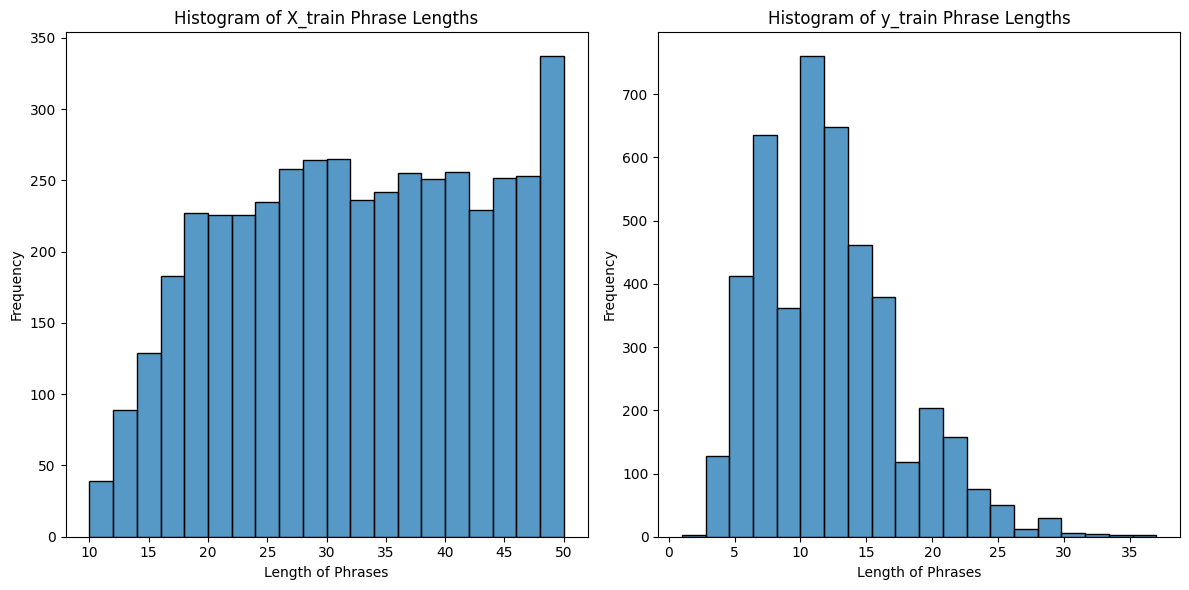

4452 Amanda baked cookies and will bring Jerry some tomorrow
Vocabulary loaded from file.
vocabulary size 11342


In [2]:

import seaborn as sns
import matplotlib.pyplot as plt

helper=Helper()
def load_x_y_train_plain():
    with open('corpus/train.json', 'r', encoding='utf-8') as f:
        try:
            dataset = json.load(f)  # Load the JSON data

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
    X_train = []
    y_train = []

    # #Loop through the list and process each dialogue and summary
    for data in dataset:
        dialogue = data['dialogue']  # Split dialogue into a list of lines
        summary = data['summary']

        X_train.append(remove_punctuation(dialogue))
        y_train.append(remove_punctuation(summary))
    return X_train, y_train

 


# with open('data/vocabolary_full.pkl', 'rb') as f:
#     vocabulary=pickle.load(f)
def filter_train_data(X_train, y_train, to_eliminate):
    filtered_X_train = []
    filtered_y_train = []

    for x, y in zip(X_train, y_train):
        if not any(to_eliminate_str in x for to_eliminate_str in to_eliminate):
             
            filtered_X_train.append(remove_punctuation(x))
            filtered_y_train.append(remove_punctuation(y))

    return filtered_X_train, filtered_y_train


def create_complete_vocabulary(X_train, y_train,max_v,name):
    nlp_model = spacy.load('en_core_web_lg')
    nlp_model.disable_pipes(["parser", "ner"])
    complete_text_target = ' '.join(y_train)
    complete_text_origin = ' '.join(X_train)
    complete_text = complete_text_target + " [START] [PAD] [END] " + complete_text_origin

    vocabulary = helper.create_vocabulary(complete_text, name, nlp_model)
    print("vocabulary size", len(vocabulary))
    return vocabulary


X_train, y_train = load_x_y_train_plain()
# to_eliminate = [
#     "[I hope I'm not coming off as rude - If I am, I'm sorry. I just thought it would be beneficial for the both of us...]",
#     "[pulls back the curtain and checks out the window]",
#     "[hopefully, masses of]"]
# X_train, y_train = filter_train_data(X_train, y_train, to_eliminate)


sample = [i for i in range(0,len(y_train))]


X_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in X_train]
y_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', y) for y in y_train]


min_v = 10
max_v = 50


y_train = [y_train[i] for i in sample if len(X_train[i]) <= max_v and len(X_train[i]) >= min_v]
X_train = [X_train[i] for i in sample if len(X_train[i]) <= max_v and len(X_train[i]) >= min_v]



# Calculate lengths of the tokenized phrases


def plot_lenghts(X_train,y_train):
    X_lengths = [len(x) for x in X_train]
    y_lengths = [len(y) for y in y_train]
    # Plot histograms
    plt.figure(figsize=(12, 6))

    # Histogram for X_train lengths
    plt.subplot(1, 2, 1)
    sns.histplot(X_lengths, bins=20, kde=False)
    plt.title('Histogram of X_train Phrase Lengths')
    plt.xlabel('Length of Phrases')
    plt.ylabel('Frequency')

    # Histogram for y_train lengths
    plt.subplot(1, 2, 2)
    sns.histplot(y_lengths, bins=20, kde=False)
    plt.title('Histogram of y_train Phrase Lengths')
    plt.xlabel('Length of Phrases')
    plt.ylabel('Frequency')

    # Display the plots
    plt.tight_layout()
    plt.show()

#X_train=[i[::-1] for i in y_train]
plot_lenghts(X_train,y_train)
 

X_train=[" ".join(x) for x in X_train]
y_train=[" ".join(y) for y in y_train]

print(len(y_train),y_train[0])
name=f"vocabolary_fultest{max_v}{min_v}"
vocabulary=create_complete_vocabulary(X_train, y_train,max_v,name)
index_based_vocabulary=dict()
for word,(vect,pos) in vocabulary.items():
    index_based_vocabulary[pos]=word

In [3]:
X_train[0:3],y_train[0:3]

(['Amanda I baked cookies Do you want some \n Jerry Sure \n Amanda Ill bring you tomorrow',
  'Olivia Who are you voting for in this election \n Oliver Liberals as always \n Olivia Me too \n Oliver Great',
  'Edward Rachel I think Im in ove with Bella \n rachel Dont say anything else \n Edward What do you mean \n rachel Open your fuing door Im outside'],
 ['Amanda baked cookies and will bring Jerry some tomorrow',
  'Olivia and Olivier are voting for liberals in this election',
  'Edward thinks he is in love with Bella Rachel wants Edward to open his door Rachel is outside'])

In [4]:
vocabulary["hi"]

(array([4.36, 0.642, 3.66, 1.28e-05, -4.96, -3.76, -0.72, -3.87, -6.41, -2.2, -1.41, 2.04, -6.14, 1.5, 0.0749, -2.84, -0.69, 1.02, -2.39, -2.48, 4.8, 0.409, -0.595, -9.68, 1.01, -2.62, 1.62, -1.28, -3.36, 2.54, -8.26, -2.06, -3.59, 2.56, 3.42, 4.83, -4.73, 1.45, 1.95, -3.57, 0.711, -4.07, -2.38, 2.93, -1.04, 0.807, -10.4, 1.01, -2.36, 4.67, -5.65, -8.97, -0.0444, 0.406, 5.98, -2.7, 3.15, 1.74, 0.803, 2.41, 2.22, 4.96, -2.34, -5.5, 0.107, -1.84, -3.34, 5.73, -2.7, 1.66, -1.93, 1.43, 5.99, -12.5, 0.562, -5.37, 1.94, -2.24, 2.37, -7.11, 1.86, -6.78, 1.91, -4.02, -2.38, 2.46, 11.7, 4.9, 2.19, -3.72, 2.3, -0.689, 2.56, -3.24, -6.29, 2.85, 0.306, -6.82, 2.37, 3.29, -3.64, 2.86, 1.97, -4.42, 2.47, 4.65, 5.46, 0.32, -6.8, 3.07, -11.7, -1.96, 11.2, 2.73, 0.346, 3.32, 7.52, -3.86, 5.57, -8.39, -5.25, -1.62, 4.82, 6.21, 2.04, 2.07, -5.04, -0.343, -2.45, 3.21, 0.221, 1.75, 1.28, -1.19, 4.11, -1.43, -1.99, -5.08, 1.5, 4.04, -3.38, -0.534, 5.4, -2.7, 6.03, -2.73, 1.85, 0.919, 5.87, 0.668, -1.23, -0.

In [5]:
len(X_train),len(vocabulary)

(4452, 11342)

In [6]:
import traceback
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.158, random_state=42)
len(y_test),len(X_test)
embedding_size=300
fl1_size=2048
batch_size=64
num_heads=5
dropout_rate=0.2 
num_batches_per_epoch = len(X_train) // batch_size
num_epochs=550
tot_loss_epoch=0
learning_rate=0.0001
clipping_threshold=1e10
tot_loss_epoch=0
temperature=1
 
decoder_seq_len=max_v
encoder_seq_len=max_v

n_layers=1
Output_stack=output_stack(embedding_size,len(vocabulary),threshold=clipping_threshold,temperature=2)
encoder=Encoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size,encoder_seq_len,clipping_threshold)
decoder=Decoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size,decoder_seq_len,clipping_threshold)

# encoder_second=Encoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size,encoder_seq_len,clipping_threshold)
# decoder_second=Decoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size,decoder_seq_len,clipping_threshold)

# encoder_third=Encoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size,encoder_seq_len,clipping_threshold)
# decoder_third=Decoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size,decoder_seq_len,clipping_threshold)
MyTransformer=Transformer(n_layers,embedding_size,num_heads,fl1_size,learning_rate,batch_size,encoder_seq_len,decoder_seq_len,clipping_threshold,vocabulary,index_based_vocabulary)
output_linear_layer=linear_layer(embedding_size,len(vocabulary),out=True) 
accuracies=[0,0]
mean_acc=0 
validation_accuracies=[0]
def print_word_from_vocabulary(word_index,vocabulary): 
    for word,(vector,position), in vocabulary.items():
        if position==word_index:
            return word
@log_time       
def training_accuracy_cross_entropy(SigmaZout,target_decoder):
    taccuracies=[]
    for n in range(SigmaZout.shape[0]): 
            len_phrase=SigmaZout.shape[1]
            counter_beccate=0 
            for l in range(SigmaZout.shape[1]): 
                if np.argmax(SigmaZout[n][l])==np.argmax(target_decoder[n][l]): 
                    counter_beccate+=1
                    print(np.argmax(target_decoder[n][l]),np.argmax(SigmaZout[n][l]))
            phrase_accuracy=counter_beccate/len_phrase
            taccuracies.append(phrase_accuracy)
    return np.mean(np.array(taccuracies))


def sparse_cross_entropy_validation(X_validation,y_validation,batch_size,transformer,Output_stack,vocabulary,encoder_seq_len,decoder_seq_len,embedding_size):
    num_batches_per_epoch = len(X_validation) // batch_size
    counter=0
    val_acc=[]
    for i in range(0,num_batches_per_epoch):
        #try: 
         
        start = i * batch_size
        end = start + batch_size 
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]  
        inputs_e_val,_,mask_e,_=helper.create_input_encoder(X_batch,vocabulary,encoder_seq_len,embedding_size) 
        mask_e=cp.transpose(mask_e,(0,2,1)) 
        inputs_decoder_val,_,mask_d,_=helper.create_decoder_input(y_batch,embedding_size,decoder_seq_len,vocabulary) 
        mask_d=cp.transpose(mask_d,(0,2,1)) 
        target_decoder_val,_,mask_t=helper.create_target_sparse(y_batch,vocabulary,decoder_seq_len)
        mask_t=cp.transpose(mask_t,(0,2,1)) 
        
        Dout=transformer.forward(inputs_e_val,inputs_decoder_val,X_validation,y_validation,mask_e,mask_d) 

        SigmaZout=Output_stack.forward(Dout) 
        acc=training_accuracy_sparse_cross_entropy(SigmaZout,target_decoder_val)
        val_acc.append(acc)
    return np.mean(np.array(val_acc))

def training_accuracy_sparse_cross_entropy(SigmaZout,target_decoder):
    #print(SigmaZout.shape)
    #print(target_decoder.shape)
    taccuracies=[]
    for n in range(SigmaZout.shape[0]): 
            len_phrase=SigmaZout.shape[1]
            counter_beccate=0 
            for l in range(SigmaZout.shape[1]): 
                if np.argmax(SigmaZout[n][l])==target_decoder[n][l]: 
                    counter_beccate+=1
                    #print(np.argmax(SigmaZout[n][l]),target_decoder[n][l],print_word_from_vocabulary(np.argmax(SigmaZout[n][l]),vocabulary))
            #print("-------------------------")
            phrase_accuracy=counter_beccate/len_phrase
            taccuracies.append(phrase_accuracy)

    
    return np.mean(np.array(taccuracies))   

In [7]:
len(X_train)*0.1

374.8

In [ ]:
 
for epoch in range(10):
     
        

    print("Loss",tot_loss_epoch/num_batches_per_epoch,"mean accuracy",np.mean(np.array(accuracies)),"mean accuracy validation",np.mean(np.array(validation_accuracies)))#np.mean(np.array(accuracies))
    tot_loss_epoch=0
    total_accuracy_epoch=0
    mean_acc=0
    accuracies=[]
     
    for i in tqdm(range(0,num_batches_per_epoch),desc=f"Epoch {epoch + 1}/{num_epochs}"):
        #try: 
        start = i * batch_size
        end = start + batch_size 
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]  
        
        inputs_e,input_e_words,mask_e,word_indexes_encoder=helper.create_input_encoder(X_batch,vocabulary,encoder_seq_len,embedding_size) 
        mask_e=cp.transpose(mask_e,(0,2,1))
        # print("inputs_e.shape",inputs_e.shape)
        # helper.print_matrix("input_e_words",input_e_words)
        # helper.print_matrix("word_indexes_encoder",word_indexes_encoder)
        # helper.print_matrix("mask_e",mask_e)
        inputs_decoder,inputs_decoder_words,mask_d,word_indexes_decoder=helper.create_decoder_input(y_batch,embedding_size,decoder_seq_len,vocabulary) 
        mask_d=cp.transpose(mask_d,(0,2,1))
        # print(inputs_decoder.shape) 
        # helper.print_matrix("inputs_decoder_words",inputs_decoder_words)
        # helper.print_matrix("mask_d",mask_d)
        # print("word_indexes_decoder",word_indexes_decoder)


        target_decoder,target_decoder_words,mask_t=helper.create_target_sparse(y_batch,vocabulary,decoder_seq_len) 
        
        
        mask_t=cp.transpose(mask_t,(0,2,1))
        
        # helper.print_matrix("target_decoder_words",target_decoder_words)
        # helper.print_matrix("mask_t",mask_t)
        # print("mask_e.shape",mask_e.shape)
        # print("mask_d.shape",mask_d.shape)
        # print("mask_t.shape",mask_t.shape)
        
   
        
        Dout=MyTransformer.forward(inputs_e,inputs_decoder,X_batch,y_batch,mask_e,mask_d) 

        SigmaZout=Output_stack.forward(Dout)
        #print(SigmaZout.shape)
        batch_accuracy=training_accuracy_sparse_cross_entropy(SigmaZout,target_decoder)
        accuracies.append(batch_accuracy) 
        
        
 
        Loss = Output_stack.sparse_categorical_crossentropy(SigmaZout,target_decoder,mask_t) 
        #print("Loss",Loss,"Batch accuracy",batch_accuracy)
        tot_loss_epoch+=Loss
 
        dL_dDout = Output_stack.grad_sparse_cross_entropy(SigmaZout,target_decoder,mask_t) 
        #print(dL_dDout.shape)
        dL_dInput_encoder,dL_dInput_decoder=MyTransformer.backpropagation(dL_dDout,inputs_decoder_words,input_e_words)#dL_Ecout,dLoss_dWemb_encoder_tot,dLoss_dWemb_decoder_tot=
        
#  

        Output_stack.update_weights(learning_rate)
        
        vocabulary=MyTransformer.update_embeddings(inputs_decoder,inputs_e,dL_dInput_decoder,dL_dInput_encoder,inputs_decoder_words,input_e_words,learning_rate,vocabulary)
 
        
        # vocabulary=helper.update_wembedding_decoder(0.00001,y_batch, dLoss_dWemb_decoder_tot,vocabulary, decoder_seq_len)
        # vocabulary=helper.update_wembedding_encoder(0.00001,X_batch, dLoss_dWemb_encoder_tot,vocabulary,encoder_seq_len)
    val_acc=sparse_cross_entropy_validation(X_test,y_test,batch_size,MyTransformer,Output_stack,vocabulary,encoder_seq_len,decoder_seq_len,embedding_size)
    validation_accuracies.append(val_acc)

Loss 0.0 mean accuracy 0.0 mean accuracy validation 0.0


Epoch 1/550: 100%|██████████| 58/58 [02:02<00:00,  2.11s/it]


Loss 7.787074901430996 mean accuracy 0.6803286637931035 mean accuracy validation 0.3693607954545454


Epoch 2/550:  97%|█████████▋| 56/58 [02:26<00:05,  2.59s/it]

In [ ]:
@log_time       
def training_accuracy_cross_entropy_teacher_forcing(SigmaZout,target_decoder):
    taccuracies=[]
    counter_beccate=0
    for n in range(SigmaZout.shape[0]): 
            if np.argmax(SigmaZout[n])==np.argmax(target_decoder[n]): 
                    counter_beccate+=1
                    #print(np.argmax(target_decoder[n][l]),np.argmax(SigmaZout[n][l])) 
    batch_accuracy=counter_beccate/SigmaZout.shape[0]
    taccuracies.append(batch_accuracy)
    return np.mean(np.array(taccuracies))

for epoch in range(num_batches_per_epoch):
    print("Loss",tot_loss_epoch/num_batches_per_epoch,"mean accuracy",np.mean(np.array(accuracies)))#np.mean(np.array(accuracies))
    tot_loss_epoch=0
    total_accuracy_epoch=0
    mean_acc=0
    accuracies=[]
    for i in tqdm(range(0,num_batches_per_epoch),desc=f"Epoch {epoch + 1}/{num_epochs}"):
        #try: 
        start = i * batch_size
        end = start + batch_size 
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]  
        
        inputs_e,input_e_words,mask_e=helper.create_input_encoder(X_batch,vocabulary,encoder_seq_len,embedding_size) 
        inputs_decoder,inputs_decoder_words,mask_d=helper.create_decoder_input_teacher_forcing(y_batch,embedding_size,decoder_seq_len,vocabulary) 
        #target_decoder,target_decoder_words,mask_t=helper.create_target_sparse(y_batch,vocabulary,decoder_seq_len) 
        mask_e=cp.transpose(mask_e,(0,2,1))
        mask_d=cp.transpose(mask_d,(0,2,1))
        #mask_t=cp.transpose(mask_t,(0,2,1))
        # print("inputs_e.shape",inputs_e.shape)
        # helper.print_matrix("input_e_words",input_e_words)
        # helper.print_matrix("mask_e",mask_e)
        #helper.print_matrix("inputs_decoder_words",inputs_decoder)
        # helper.print_matrix("mask_d",mask_d)
        # helper.print_matrix("target_decoder_words",target_decoder_words)
        # helper.print_matrix("mask_t",mask_t)
        # print("mask_e.shape",mask_e.shape)
        # print("mask_d.shape",mask_d.shape)
        # print("mask_t.shape",mask_t.shape)
        
        
        Ecout=encoder.forward(inputs_e,mask_e)
 
        target_d=helper.pad_sequences(y_batch,lenght=decoder_seq_len,target_type="target")
            
        target_d=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in target_d] 
        #print_matrix(target_d) 
        dL_Ecout_tot=0
        tot_loss=0
        for step in range(0,inputs_decoder.shape[0]):
                inputs_d=inputs_decoder[step]
                #mask_d = cp.array([1 if x <= step else 0 for x in range(decoder_seq_len)]).T
                mask_d=cp.array([cp.array([1 if x <= step else 0 for x in range(decoder_seq_len)]).T for _ in range(batch_size)])
                mask_d=np.expand_dims(mask_d,axis=2)
                #print(mask_d.shape)
                target=cp.array([helper.get_one_hot(x[step], vocabulary) for x in target_d])
                #print(inputs_d.shape)
                Dout=decoder.forward(inputs_d,Ecout,mask_d,mask_e) 
                #print(Dout.shape)
                Dout=Dout[:, step, :]
                #Dout=Dout.reshape(Dout.shape[0],Dout.shape[1]*Dout.shape[2])
                SigmaZout=Output_stack.forward(Dout)
                #print(SigmaZout.shape,target.shape)
                batch_accuracy=training_accuracy_cross_entropy_teacher_forcing(SigmaZout,target)
                accuracies.append(batch_accuracy) 
                
        
                Loss = Output_stack.cross_entropy_loss(SigmaZout,target) #mask_t
                #print("Loss",Loss)#"Batch accuracy",batch_accuracy
                tot_loss+=Loss
        
                dL_dDout = Output_stack.grad_cross_entropy(SigmaZout,target) #mask_t
                #print(dL_dDout.shape)
                dL_dDout=cp.tile(dL_dDout[:, cp.newaxis, :], (1, decoder_seq_len, 1))
                
                #dL_dDout=dL_dDout.reshape(batch_size,decoder_seq_len,embedding_size)
                
                dL_Ecout,dL_inputs_decoder,dLoss_dWemb_decoder=decoder.backpropagation(dL_dDout)
                dL_Ecout_tot+=dL_Ecout
                _=decoder.update_weights(learning_rate,vocabulary)
                Output_stack.update_weights_tf(learning_rate)
        tot_loss_epoch+=tot_loss/inputs_decoder.shape[0]
        #dL_Ecout,dLoss_dWemb_encoder_tot,dLoss_dWemb_decoder_tot=MyTransformer.backpropagation(dL_dDout)
        dL_inputs_e,dLoss_dWemb_encoder=encoder.backpropagation(dL_Ecout_tot)
        _=encoder.update_weights(learning_rate,vocabulary)
#  

        
        
 
        
        #vocabulary=helper.update_wembedding_decoder(0.00001,y_batch, dLoss_dWemb_decoder_tot,vocabulary, decoder_seq_len)
        #vocabulary=helper.update_wembedding_encoder(0.00001,X_batch, dLoss_dWemb_encoder_tot,vocabulary,encoder_seq_len)



Loss 0.00843914658577071 mean accuracy 0.0


Epoch 1/550:   0%|          | 0/1113 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 3)

To identify where to place − ∞ −∞ values in 𝑄 𝐾 scaled QK scaled ​ , consider how the mask interacts with the sequence positions. Shape of 𝑄 𝐾 scaled QK scaled ​ : For a batch size of 𝑁 N, 𝑄 𝐾 scaled QK scaled ​ typically has the shape ( 𝑁 , num_heads , seq_len , seq_len ) (N,num_heads,seq_len,seq_len), where seq_len seq_len is the length of the input sequence. Each element in 𝑄 𝐾 scaled [ 𝑖 , ℎ , 𝑗 , 𝑘 ] QK scaled ​ [i,h,j,k] represents the attention score between the 𝑗 j-th query position and the 𝑘 k-th key position for the ℎ h-th attention head in the 𝑖 i-th batch item. Mask Shape Alignment: The mask typically has shape ( 𝑁 , seq_len ) (N,seq_len) and marks each position with a 1 (for valid tokens) or a 0 (for padding tokens). To align with 𝑄 𝐾 scaled QK scaled ​ , you expand the mask to shape ( 𝑁 , 1 , 1 , seq_len ) (N,1,1,seq_len). After expansion, the mask will effectively broadcast over the query positions (dimension 2 of 𝑄 𝐾 scaled QK scaled ​ ) and attention heads (dimension 1). Applying − ∞ −∞ Masking: When broadcasting the mask, only key positions that correspond to padding tokens (mask=0) in the last dimension will be assigned − ∞ −∞. This is why adding ( mask − 1 ) × 1 0 9 (mask−1)×10 9 works; any position where the mask is 0 will add − 1 0 9 −10 9 to 𝑄 𝐾 scaled QK scaled ​ , effectively zeroing out the attention after the softmax. So, for every padding token position (where mask[i, k] = 0), every attention score 𝑄 𝐾 scaled [ 𝑖 , : , : , 𝑘 ] QK scaled ​ [i,:,:,k] will be set to a large negative value, ensuring no attention is paid to padding tokens across all queries and heads.

In [ ]:
Dout

array([[1.37, -1.45, 2.02, -0.26, 0.333, -0.391, 1.99, -0.604, -0.584, 0.184, 0.922, -0.555, -0.528, 0.44, -0.242, 0.749, 1.24, 0.674, -0.0289, 0.0349, -0.418, -0.262, -0.415, -0.931, -1.76, -0.447, 0.703, 2.63, 0.596, -0.222, -1.3, 0.0114, 0.596, -0.87, -0.492, 0.0834, -0.616, 0.361, 1.03, 2.06, -0.77, 0.471, 0.344, 2.18, 0.541, -2.58, 2.16, -1.38, 1.61, 0.0977, -0.866, 0.659, -0.834, 0.855, -2.03, 0.000912, 1.22, -1.42, 0.258, -0.855, -0.123, -1.12, -1.07, -0.63, -0.0727, -0.0296, -2.37, 0.993, -1.82, -0.436, 0.612, 0.438, 0.221, 1.24, -0.135, -0.894, 0.155, 0.167, 0.0837, 1.14, -0.236, -0.657, 0.111, -0.463, -0.538, -0.847, -0.551, -0.581, 0.755, 0.68, -0.635, -0.585, -1.22, -1.84, -0.29, 1.83, -0.583, -1.74, -0.512, -0.712, -0.43, 1.1, 0.947, -0.572, -0.66, -0.528, 3.82, 0.223, -0.0052, -1.21, 2.11, 0.419, 0.108, 0.54, 1.22, 0.569, 0.222, -0.577, 0.886, -1.54, 0.354, 0.892, 0.447, 0.0819, -0.168, 0.188, -0.292, -0.616, -0.298, -2.27, -1.56, -0.397, 0.899, -1.08, -1.36, 1.34, 0.682,

In [ ]:
np.tile(Dout[:, np.newaxis, :], (1, 13, 1)).shape

(3, 13, 300)

In [ ]:
for i,(j,k) in vocabulary.items():
    #print(i,k)
    if k==775:
        print(i)

prepare


In [ ]:
vocabulary["[PAD]"]

(array([7.29, -4.52, 6.58, -2.67, -1.89, 1.38, 4.31, -3.22, -10.3, -1.86, -0.165, -2.48, 9.21, 0.397, 1.59, 7.13, -6.91, 4.72, -1.58, -0.172, 4.32, 3.8, 1.43, -5.23, -7.19, 1.69, 4.76, 6.03, -3.68, -4.43, -0.472, -1.38, 6.1, 2.23, 0.887, -5.05, -1.16, 0.472, 6.07, 6.63, 1.5, -2.8, -7.84, 8.3, 2.25, -13.7, 4.49, 1.6, 3.39, -6.48, -7.28, -0.184, -2.28, -3.54, -4.86, 4.98, 6.52, -3.3, 7.13, -2.69, -0.978, -2.03, -4.34, -0.0675, -4.21, 3.58, -9.06, 0.371, 0.468, 1.56, 0.745, -5.18, -5.34, -5.32, -0.718, 0.632, 1.63, 3.74, -2.94, 5.61, -0.722, -3.61, -3.2, -1.7, -5.03, -1.62, 1.89, -1.64, 6.58, 2.95, -10.6, 1.52, -6.33, -7.92, -5.77, 4.34, -0.0952, -1.63, -0.553, -0.957, 0.99, -2.37, 3.49, -3.04, 1.74, 4.95, 11.8, 0.265, -4.32, 5.9, 3.63, 0.339, 2.86, -1.67, -1.76, 0.766, -3.32, 4.36, -0.622, -1.46, 4.53, 1.96, 0.922, -0.981, 2.86, 2.27, 2.65, 1.67, 0.0472, -3.75, -6.28, -1.6, 2.4, -0.826, 4.83, -6, -0.0516, 1.95, -1.24, 4.48, -3.47, -0.587, -5.91, 3.51, -4.78, -0.428, -4.84, 0.476, 10.3, 1

In [ ]:
3,50,300

(3, 50, 300)

In [ ]:
3, 15, 300 #dAttention.shape 
3, 10, 15, 50 #dAttention_weights
3, 10, 50, 30 #self.K
3, 10, 50, 30 #self.V
300, 300#k.W

(300, 300)

In [ ]:
3, 15, 300
3, 10, 15, 50
3, 10, 50, 30
3, 50, 300#self.helper.redimension(self.V)
300, 300

(300, 300)

In [ ]:
3, 15, 300
3, 10, 15, 50
3, 10, 50, 30
3, 50, 300#self.helper.redimension(self.V)@self.k.W

(3, 50, 300)

In [ ]:
3, 15, 300
3, 10, 15, 30#dAttention_weights@self.K
3, 50, 300

(3, 50, 300)

In [ ]:
3, 15, 300
3, 15, 300#self.helper.redimension(dAttention_weights@self.K)
3, 50, 300

(3, 50, 300)

In [ ]:
3, 300, 300#dAttention*self.helper.redimension(dAttention_weights@self.K)
3, 50, 300

(3, 50, 300)